In [339]:

#pip install urduhack
!pip install LughaatNLP

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [340]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Reshape, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten
#import urduhack
#from urduhack.preprocessing import normalize_whitespace, remove_punctuation
#from urduhack.tokenization import word_tokenizer
#from urduhack.normalization import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


# Applyig Models Before text Generation

In [341]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from LughaatNLP import LughaatNLP
from LughaatNLP import POS_urdu
from LughaatNLP import NER_Urdu
urdu_text_processing = LughaatNLP()
ner_urdu = NER_Urdu()
pos_tagger = POS_urdu()
 
# Define a preprocessing function
def preprocess_and_tokenize(text):
    # Normalize the text
    normalized_text = urdu_text_processing.normalize(text)
    # Remove stop words
    no_stopwords_text = urdu_text_processing.remove_stopwords(normalized_text)
    # Lemmatize the text
    lemmatized_text = urdu_text_processing.lemmatize_sentence(no_stopwords_text)
    # Tokenize the text
    tokens = urdu_text_processing.urdu_tokenize(lemmatized_text)
    cleaned_text = ' '.join(tokens)  # Convert tokens back to a single string
    return cleaned_text,tokens


# Define a list of Urdu stop word
urdu_stop_words = ["کے", "میں", "کی", "کا", "ہے", "کو", "سے", "پر", "اور", "تو", "یہ", "ہے", "بھی", "ہے", "تھا", "تھی", "ہوں"]

# Updated helper function for data preprocessing
def preprocess_text_algos(text):
    text = normalize(text)
    text = normalize_whitespace(text)
    text = remove_punctuation(text)
    tokens = word_tokenizer(text)
    filtered_tokens = [token for token in tokens if token not in urdu_stop_words]  # Remove stop words
    cleaned_text = ' '.join(filtered_tokens)  # Convert tokens back to a single string
    return cleaned_text, filtered_tokens

def store_results(model_name, y_test, y_pred, results_df=None):
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Create a DataFrame for the current results
    current_results = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'F1 Score': [f1],
        'Recall': [recall],
        'Precision': [precision]
    })
    
    # Initialize or concatenate results
    if results_df is None:
        results_df = current_results
    else:
        results_df = pd.concat([results_df, current_results], ignore_index=True)
    
    return results_df

# Example usage:
results_df = None

## Data Loading

In [342]:
# data loading 
dataset_path = "/kaggle/input/urdu-news-csv/news.csv"

df = pd.read_csv(dataset_path, encoding='utf-8')
print("shape of data before tex gen:",df.shape)
df.head()

shape of data before tex gen: (4097, 3)


,Unnamed: 0,news,label
0,0,"; ""تفصیلات کے مطابق بحریہ ٹاؤن کی جانب سے بتی...",real
1,1,"; ""قصور میں مرد اور خاتون کی پھندا لگی لاشیں ب...",real
2,2,"; ; ""تفصیلات کے مطابق داروغہ والا میں دیرینہ د...",real
3,3,"; ""سیشن جج لاہور نے مجرم محمد اشرف کے بلیک ورا...",real
4,4,"; ""آج ملزمہ انیقہ نے عدالت میں بیان بدل دیا، ...",real


## Data PreProcessing 

Removoing unanted columns, missing values  etc

In [343]:
# droping un named column and randomizing data
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,news,label
0,\tپاکستان کے صوبے پنجاب میں گذشتہ ہفتے ہونے وا...,real
1,\tوزیر اعظم عمران خان کے ساجد گوندل کی بازیابی...,real
2,لاہور(کلچرل رپورٹر)ایشین ایکسی لینس پرفارمنس ا...,fake
3,امریکی خواتین سوکر اسٹار میگن ریپینو گھٹنوں کے...,fake
4,\tوفاق ہو یا صوبے، خیبر پختونخواہ ہو یا پنجاب،...,real


In [344]:
print("Unique labels before cleaning:",df['label'].unique())

Unique labels before cleaning: ['real' 'fake ']


In [345]:
# as there is a space in label fake in pur data set so strip it
df['label'] = df['label'].str.strip()
df['news']= df['news'].str.strip()
print("Unique labels after cleaning:", df['label'].unique())

Unique labels after cleaning: ['real' 'fake']


In [346]:
# data after remiving space and un named column
print(df.shape)
df.head()

(4097, 2)


,news,label
0,پاکستان کے صوبے پنجاب میں گذشتہ ہفتے ہونے والے...,real
1,وزیر اعظم عمران خان کے ساجد گوندل کی بازیابی ک...,real
2,لاہور(کلچرل رپورٹر)ایشین ایکسی لینس پرفارمنس ا...,fake
3,امریکی خواتین سوکر اسٹار میگن ریپینو گھٹنوں کے...,fake
4,وفاق ہو یا صوبے، خیبر پختونخواہ ہو یا پنجاب، ُ...,real


## Making Copies of data to impliment strategies

In [347]:
org_data = df.copy()  # copy for applying algos and generating text
initial_data = df.copy() # copy for merging sythesis data in it
print("data set shape before text geenration ",org_data.shape)
org_data.head()

data set shape before text geenration  (4097, 2)


,news,label
0,پاکستان کے صوبے پنجاب میں گذشتہ ہفتے ہونے والے...,real
1,وزیر اعظم عمران خان کے ساجد گوندل کی بازیابی ک...,real
2,لاہور(کلچرل رپورٹر)ایشین ایکسی لینس پرفارمنس ا...,fake
3,امریکی خواتین سوکر اسٹار میگن ریپینو گھٹنوں کے...,fake
4,وفاق ہو یا صوبے، خیبر پختونخواہ ہو یا پنجاب، ُ...,real


## EDA

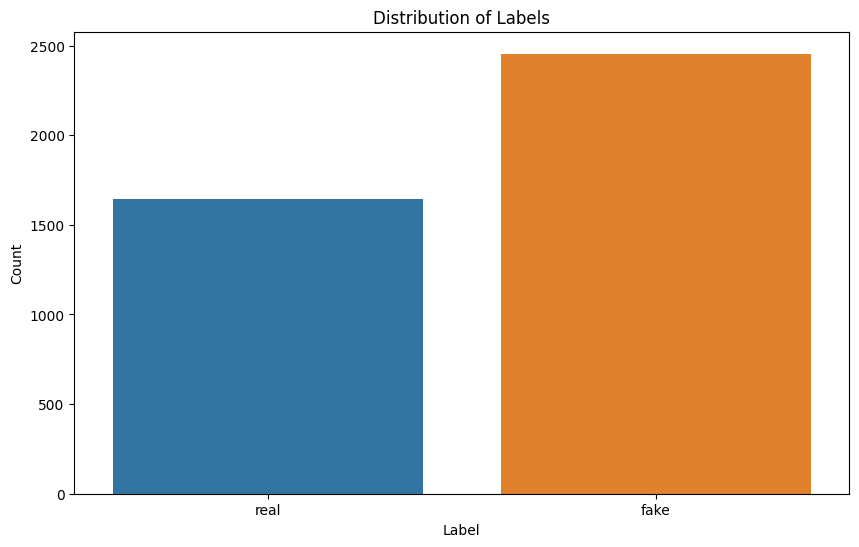

In [348]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Distribution of Labels
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=org_data)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Cheking class imbalance 

In [349]:
import pandas as pd

# Calculate the value counts of 'label'
label_counts = org_data['label'].value_counts()

# Print the counts
print("Number of Fake News:", label_counts['fake'])
print("Number of Real News:", label_counts['real'])

# Calculate the difference
difference = label_counts['fake'] - label_counts['real']
print("Difference (Fake - Real):", difference)


Number of Fake News: 2455
Number of Real News: 1642
Difference (Fake - Real): 813


> so e have to create more 813 real news to balance the data set

## Cheking label Percentages in overall dataset

Percentage of Labels Fake and real : label
fake    59.921894
real    40.078106
Name: count, dtype: float64


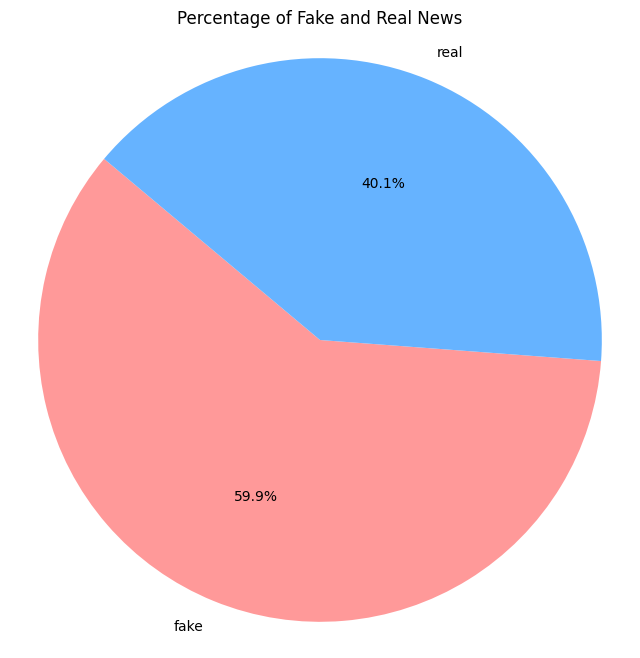

In [350]:
label_counts = org_data['label'].value_counts()
label_percentages = (label_counts / label_counts.sum()) * 100
print("Percentage of Labels Fake and real :",label_percentages)
# Plot the percentages using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_percentages, labels=label_percentages.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Percentage of Fake and Real News')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Sampling 
 > as our resources are limited so we will use samopling but by taking in mind our real proportion is maintained

In [351]:
import pandas as pd

# Calculate the percentage of each label
label_percentages = org_data['label'].value_counts(normalize=True) * 100
print(label_percentages)

# Define the total number of samples you want
total_samples = 4097  # Change to 4097 if you want to apply on noverall data 

# Calculate the number of samples for each label
num_fake_samples = int(total_samples * (label_percentages['fake'] / 100))
num_real_samples = total_samples - num_fake_samples

# Sample the required number of fake and real news
fake_samples = org_data[org_data['label'] == 'fake'].sample(num_fake_samples, random_state=42)
real_samples = org_data[org_data['label'] == 'real'].sample(num_real_samples, random_state=42)

# Concatenate the samples to create the final dataset
sampled_data = pd.concat([fake_samples, real_samples]).reset_index(drop=True)

# Verify the new dataset
print(sampled_data['label'].value_counts(normalize=True) * 100)

# Now you can proceed with further analysis or machine learning tasks on the sampled_data


label
fake    59.921894
real    40.078106
Name: proportion, dtype: float64
label
fake    59.921894
real    40.078106
Name: proportion, dtype: float64


In [352]:
# again named to our original data name
sampled_data = sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)
org_data=sampled_data.copy()

In [353]:
print(org_data.shape)
org_data.head()

(4097, 2)


,news,label
0,کینیڈا کے وزیر اعظم جسٹن ٹروڈو نے جمعرات کو ای...,fake
1,جیمز فولی کی والدہ امریکی حکومت سے معاملہ سنبھ...,fake
2,برطانیہ میں نئےکورونا وائرس کے پیش نظر وہاں سے...,real
3,پریس کانفرنس کرتے ہوئے مریم اورنگزیب نے اپنے و...,fake
4,ڈونلڈ ٹرمپ کی صدر کے انتخابی مہم کی ایک اہم با...,fake


# Getting Cleaned text and tokenize data 
 
 1. Cleaned text for applying machine learning algos 
 2. tokens for using in generating text

In [354]:
# Apply the preprocessing function to the news column
org_data[['cleaned_news', 'tokens']] = org_data['news'].apply(lambda x: pd.Series(preprocess_and_tokenize(x)))


In [355]:
print(org_data.shape)
org_data.head()

(4097, 4)


,news,label,cleaned_news,tokens
0,کینیڈا کے وزیر اعظم جسٹن ٹروڈو نے جمعرات کو ای...,fake,کینیڈا وزیر اعظم جسٹن ٹروڈو جمعرات فورم شرکت ک...,"[کینیڈا, وزیر, اعظم, جسٹن, ٹروڈو, جمعرات, فورم..."
1,جیمز فولی کی والدہ امریکی حکومت سے معاملہ سنبھ...,fake,جیمز فولی والدہ امریکی حکومت معاملہ سنبھلنا ' ...,"[جیمز, فولی, والدہ, امریکی, حکومت, معاملہ, سنب..."
2,برطانیہ میں نئےکورونا وائرس کے پیش نظر وہاں سے...,real,برطانیہ نئےکورونا وائرس پیش نظر مسافر ۲۲ دسمبر...,"[برطانیہ, نئےکورونا, وائرس, پیش, نظر, مسافر, ۲..."
3,پریس کانفرنس کرتے ہوئے مریم اورنگزیب نے اپنے و...,fake,پریس کانفرنس مریم اورنگزیب والد نواز شریف بھان...,"[پریس, کانفرنس, مریم, اورنگزیب, والد, نواز, شر..."
4,ڈونلڈ ٹرمپ کی صدر کے انتخابی مہم کی ایک اہم با...,fake,ڈونلڈ ٹرمپ صدر انتخابی مہم اہم بات ملازمت گھر ...,"[ڈونلڈ, ٹرمپ, صدر, انتخابی, مہم, اہم, بات, ملا..."


## Applying Models Before text generation

## Data Splitting for Models

In [356]:
 #Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(org_data['cleaned_news'])

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(org_data['label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Applying Adaboost Before Text generation

In [357]:
# applying Adaboost before text generation
# AdaBoost implementation

print("Applying ad aboost before text Generation")
model = AdaBoostClassifier(n_estimators=10,learning_rate=0.01 ,random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy: (ada boost before Text-Generation)", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))
results_df =store_results("ada boost before Text-Generation",y_test,y_pred,results_df)



Applying ad aboost before text Generation
Accuracy: (ada boost before Text-Generation) 0.6060975609756097
              precision    recall  f1-score   support

        fake       0.93      0.37      0.53       491
        real       0.50      0.96      0.66       329

    accuracy                           0.61       820
   macro avg       0.72      0.66      0.60       820
weighted avg       0.76      0.61      0.58       820



### Applying Gboost Before Text generation

In [358]:
# applying G boost before text geenration 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train and evaluate GBoost
gboost = GradientBoostingClassifier(n_estimators=20,learning_rate=0.01,max_depth=3)  # Decrease n_estimators from default value

gboost.fit(X_train, y_train)
y_pred_gboost = gboost.predict(X_test)
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gboost))
print("Gradient Boosting Accuracy:(G-boost before Text-Generation)", accuracy_score(y_test, y_pred_gboost))

results_df =store_results("G-boost before Text-Generation",y_test,y_pred_gboost,results_df)

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75       491
           1       0.00      0.00      0.00       329

    accuracy                           0.60       820
   macro avg       0.30      0.50      0.37       820
weighted avg       0.36      0.60      0.45       820

Gradient Boosting Accuracy:(G-boost before Text-Generation) 0.598780487804878


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Applying XGB Before Text generation

In [359]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Initialize the XGBClassifier without specifying any parameters
xgb_model_simple = xgb.XGBClassifier(n_estimators=35,learning_rate=0.01,use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit the model on training data
xgb_model_simple.fit(X_train, y_train)

# Predictions on test data
y_pred_xgb_simple = xgb_model_simple.predict(X_test)

# Evaluation
print("XGBoost Simple Classification Report:\n", classification_report(y_test, y_pred_xgb_simple, zero_division=0))
print("XGBoost Simple Accuracy:", accuracy_score(y_test, y_pred_xgb_simple))
results_df =store_results("XGB before Text-Generation",y_test,y_pred_xgb_simple,results_df)

XGBoost Simple Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.97      0.83       491
           1       0.91      0.47      0.62       329

    accuracy                           0.77       820
   macro avg       0.82      0.72      0.73       820
weighted avg       0.80      0.77      0.75       820

XGBoost Simple Accuracy: 0.7682926829268293


### Applying Logistic Regression Before Text generation

In [360]:
# Logistic Regression
print("Applying Logistic Regression")
model_lr = LogisticRegression(C=0.1 ,random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print("Accuracy: (Logistic Regression)", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_, zero_division=0))
results_df = store_results("Logistic Regression before texgen", y_test, y_pred_lr, results_df)

Applying Logistic Regression
Accuracy: (Logistic Regression) 0.7585365853658537
              precision    recall  f1-score   support

        fake       0.72      0.99      0.83       491
        real       0.96      0.41      0.58       329

    accuracy                           0.76       820
   macro avg       0.84      0.70      0.70       820
weighted avg       0.82      0.76      0.73       820



### Applying SVM Before Text generation

In [361]:
# Support Vector Machine
print("Applying Support Vector Machine")
model_svm = SVC(kernel='poly',degree=3,C=0.1,random_state=42)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
print("Accuracy: (Support Vector Machine)", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, zero_division=0))
results_df = store_results("Support Vector Machine before texgen", y_test, y_pred_svm, results_df)

Applying Support Vector Machine
Accuracy: (Support Vector Machine) 0.598780487804878
              precision    recall  f1-score   support

        fake       0.60      1.00      0.75       491
        real       0.00      0.00      0.00       329

    accuracy                           0.60       820
   macro avg       0.30      0.50      0.37       820
weighted avg       0.36      0.60      0.45       820



### Applying Random Forest Before Text generation

In [362]:
# Random Forest
print("Applying Random Forest")
model_rf = RandomForestClassifier(n_estimators=20,max_depth=5, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("Accuracy: (Random Forest)", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_, zero_division=0))
results_df = store_results("Random Forest before texgen", y_test, y_pred_rf, results_df)

Applying Random Forest
Accuracy: (Random Forest) 0.6804878048780488
              precision    recall  f1-score   support

        fake       0.65      1.00      0.79       491
        real       1.00      0.20      0.34       329

    accuracy                           0.68       820
   macro avg       0.83      0.60      0.56       820
weighted avg       0.79      0.68      0.61       820



### Applying Multinomial Naive Bayes Before Text generation

In [363]:
 #Multinomial Naive Bayes
print("Applying Multinomial Naive Bayes")
model_nb = MultinomialNB(alpha=20.0)
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
print("Accuracy: (Multinomial Naive Bayes)", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_, zero_division=0))
results_df = store_results("Multinomial Naive Bayes before texgen", y_test, y_pred_nb, results_df)

Applying Multinomial Naive Bayes
Accuracy: (Multinomial Naive Bayes) 0.6451219512195122
              precision    recall  f1-score   support

        fake       0.63      1.00      0.77       491
        real       1.00      0.12      0.21       329

    accuracy                           0.65       820
   macro avg       0.81      0.56      0.49       820
weighted avg       0.78      0.65      0.54       820



### Applying Neural Networ with 4 layers Before Text Generation

In [364]:
# applying Neural Nnetwork with  layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from scipy.sparse import csr_matrix
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

# Convert sparse matrices to dense, if necessary
X_train_dense = csr_matrix(X_train).todense()
X_test_dense = csr_matrix(X_test).todense()

# Define the neural network
nn4 = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='sigmoid'),
    Dropout(0.5),
    Dense(32, activation='sigmoid'),
    Dropout(0.5),
    #Dense(32, activation='relu'),
    #Dense(16, activation='relu'),
    Dense(2, activation='softmax')  # Use 2 neurons for two classes
])

# Compile the model with appropriate loss function and optimizer
optimizer = Adam(learning_rate=0.001)
nn4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn4.fit(X_train_dense, y_train_encoded, epochs=10, batch_size=64, verbose=1)

# Predict and evaluate the model
y_pred_nn4 = nn4.predict(X_test_dense)
y_pred_nn4 = (y_pred_nn4 > 0.5).astype("int32")

print("Neural Network (4 layers) Classification Report:\n", classification_report(y_test_encoded, y_pred_nn4,zero_division=0))
print("Neural Network (4 layers) Accuracy:(nn- before text gen)", accuracy_score(y_test_encoded.argmax(axis=1), y_pred_nn4.argmax(axis=1)))
results_df =store_results("nn4 before text gen",y_test_encoded,y_pred_nn4,results_df)


Epoch 1/10
52/52 [==============================] - 1s 5ms/step - loss: 0.7399 - accuracy: 0.5236
Epoch 2/10
52/52 [==============================] - 0s 5ms/step - loss: 0.6982 - accuracy: 0.5716
Epoch 3/10
52/52 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.5914
Epoch 4/10
52/52 [==============================] - 0s 5ms/step - loss: 0.6757 - accuracy: 0.5969
Epoch 5/10
52/52 [==============================] - 0s 5ms/step - loss: 0.6681 - accuracy: 0.6051
Epoch 6/10
52/52 [==============================] - 0s 5ms/step - loss: 0.6658 - accuracy: 0.5993
Epoch 7/10
52/52 [==============================] - 0s 5ms/step - loss: 0.6484 - accuracy: 0.6341
Epoch 8/10
52/52 [==============================] - 0s 5ms/step - loss: 0.6368 - accuracy: 0.6375
Epoch 9/10
52/52 [==============================] - 0s 5ms/step - loss: 0.6121 - accuracy: 0.6652
Epoch 10/10
26/26 [==============================] - 0s 2ms/step
Neural Network (4 layers) Classification Report:
    

### Results Before Text Generation

In [365]:
results_df.head(100)

,Model,Accuracy,F1 Score,Recall,Precision
0,ada boost before Text-Generation,0.606098,0.582492,0.606098,0.758549
1,G-boost before Text-Generation,0.598780,0.448514,0.598780,0.358538
2,XGB before Text-Generation,0.768293,0.747302,0.768293,0.803426
3,Logistic Regression before texgen,0.758537,0.729644,0.758537,0.815574
4,Support Vector Machine before texgen,0.598780,0.448514,0.598780,0.358538
5,Random Forest before texgen,0.680488,0.608437,0.680488,0.791659
6,Multinomial Naive Bayes before texgen,0.645122,0.544989,0.645122,0.777180
7,nn4 before text gen,0.759756,0.731280,0.759756,0.816306


## Cheking difference in sample selected 

In [366]:
# cheing class imbalance in our data so we have to generate how many number of real rows in order to balance data 
import pandas as pd

# Assuming org_data is your original DataFrame containing the 'label' column

# Calculate the value counts of 'label'
label_counts = org_data['label'].value_counts()

# Print the counts
print("Number of Fake News:", label_counts['fake'])
print("Number of Real News:", label_counts['real'])

# Calculate the difference
difference = label_counts['fake'] - label_counts['real']
print("Difference (Fake - Real):", difference)

Number of Fake News: 2455
Number of Real News: 1642
Difference (Fake - Real): 813


# Applying TextGAN for Text Generation

In [367]:
org_data.head()

,news,label,cleaned_news,tokens
0,کینیڈا کے وزیر اعظم جسٹن ٹروڈو نے جمعرات کو ای...,fake,کینیڈا وزیر اعظم جسٹن ٹروڈو جمعرات فورم شرکت ک...,"[کینیڈا, وزیر, اعظم, جسٹن, ٹروڈو, جمعرات, فورم..."
1,جیمز فولی کی والدہ امریکی حکومت سے معاملہ سنبھ...,fake,جیمز فولی والدہ امریکی حکومت معاملہ سنبھلنا ' ...,"[جیمز, فولی, والدہ, امریکی, حکومت, معاملہ, سنب..."
2,برطانیہ میں نئےکورونا وائرس کے پیش نظر وہاں سے...,real,برطانیہ نئےکورونا وائرس پیش نظر مسافر ۲۲ دسمبر...,"[برطانیہ, نئےکورونا, وائرس, پیش, نظر, مسافر, ۲..."
3,پریس کانفرنس کرتے ہوئے مریم اورنگزیب نے اپنے و...,fake,پریس کانفرنس مریم اورنگزیب والد نواز شریف بھان...,"[پریس, کانفرنس, مریم, اورنگزیب, والد, نواز, شر..."
4,ڈونلڈ ٹرمپ کی صدر کے انتخابی مہم کی ایک اہم با...,fake,ڈونلڈ ٹرمپ صدر انتخابی مہم اہم بات ملازمت گھر ...,"[ڈونلڈ, ٹرمپ, صدر, انتخابی, مہم, اہم, بات, ملا..."


In [368]:
# Tokenization and padding sequences  for org data
all_tokens = [token for sublist in org_data['tokens'] for token in sublist]
vocab = list(set(all_tokens))
token_to_id = {token: idx for idx, token in enumerate(vocab)}
org_data['token_ids'] = org_data['tokens'].apply(lambda tokens: [token_to_id[token] for token in tokens])
max_sequence_length = max([len(token_ids) for token_ids in org_data['token_ids']])
padded_sequences = pad_sequences(org_data['token_ids'], maxlen=max_sequence_length, padding='post')

In [369]:
# Preparing data for  GAN 
data = pd.DataFrame(padded_sequences)
data['label'] = real_news_df['label'].apply(lambda x: 1 if x == 'real' else 0)
# Remove rows with NaN values in 'label'
data = data.dropna(subset=['label'])
data['label'] = data['label'].astype(int)

for column in data.columns:
    if column != 'label':
        data[column] = data[column].astype(float)

data.columns = data.columns.astype(str)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_tensor = tf.convert_to_tensor(data_scaled, dtype=tf.float32)
label_tensor = tf.convert_to_tensor(data['label'].values, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((data_tensor, label_tensor)).shuffle(buffer_size=1024).batch(32)


In [370]:
# defoinning generator and discriminator yuo can enhance its complexity accoridng to need 
latent_dim = 100
output_dim = data_tensor.shape[1]

generator = Sequential([
    Dense(256, input_dim=latent_dim, activation='relu'),  # Increase units for more capacity
    Reshape((1, 256)),  # Reshape to feed into LSTM
    LSTM(512, return_sequences=True),  # LSTM layer with more units
    LSTM(512, return_sequences=True),  # Additional LSTM layer for more complex temporal dependencies
    LSTM(256, return_sequences=True),  # LSTM layer to adjust temporal information
    Flatten(),
    Dense(output_dim, activation='sigmoid')
])

input_dim = data_tensor.shape[1]

discriminator = Sequential([
    Reshape((1, input_dim), input_shape=(input_dim,)),
    LSTM(256, return_sequences=True),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [371]:
# Defining TextGAN
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

generator.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')


gan_input = tf.keras.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')



In [372]:
# training GAN
epochs = 100

for epoch in range(epochs):
    for real_data, _ in dataset:
        batch_size = real_data.shape[0]

        # Train Discriminator
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        z = tf.random.normal((batch_size, latent_dim))
        fake_data = generator(z)

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        z = tf.random.normal((batch_size, latent_dim))
        g_loss = gan.train_on_batch(z, real_labels)

    print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss[0]:.4f}, g_loss: {g_loss:.4f}')


Epoch [1/100], d_loss: 0.0967, g_loss: 3.2225
Epoch [2/100], d_loss: 0.0144, g_loss: 3.9772
Epoch [3/100], d_loss: 0.0088, g_loss: 4.4354
Epoch [4/100], d_loss: 0.0043, g_loss: 5.0211
Epoch [5/100], d_loss: 0.0031, g_loss: 5.4547
Epoch [6/100], d_loss: 0.0029, g_loss: 5.6698
Epoch [7/100], d_loss: 0.0031, g_loss: 5.2393
Epoch [8/100], d_loss: 0.0300, g_loss: 2.9522
Epoch [9/100], d_loss: 0.0340, g_loss: 2.7403
Epoch [10/100], d_loss: 0.0125, g_loss: 3.7235
Epoch [11/100], d_loss: 0.0068, g_loss: 4.3263
Epoch [12/100], d_loss: 0.0044, g_loss: 4.7407
Epoch [13/100], d_loss: 0.0032, g_loss: 5.0829
Epoch [14/100], d_loss: 0.0025, g_loss: 5.3404
Epoch [15/100], d_loss: 0.0020, g_loss: 5.5670
Epoch [16/100], d_loss: 0.0016, g_loss: 5.7535
Epoch [17/100], d_loss: 0.0014, g_loss: 5.9333
Epoch [18/100], d_loss: 0.0011, g_loss: 6.1370
Epoch [19/100], d_loss: 0.0010, g_loss: 6.2007
Epoch [20/100], d_loss: 0.0009, g_loss: 6.3342
Epoch [21/100], d_loss: 0.0008, g_loss: 6.4749
Epoch [22/100], d_loss

In [373]:
# generating text 
num_samples = 813 # required rows to balance data 
z = tf.random.normal((num_samples, latent_dim))
synthetic_data = generator(z).numpy()
synthetic_data = scaler.inverse_transform(synthetic_data)
print(synthetic_data)

[[1.2514200e+04 1.2289872e+04 1.1836112e+04 ... 1.1077766e+01
  2.2706084e+00 1.0000020e+00]
 [1.2514200e+04 1.2289872e+04 1.1836112e+04 ... 1.1077766e+01
  2.2706084e+00 1.0000020e+00]
 [1.2514200e+04 1.2289872e+04 1.1836112e+04 ... 1.1077766e+01
  2.2706084e+00 1.0000020e+00]
 ...
 [1.2514200e+04 1.2289872e+04 1.1836112e+04 ... 1.1077766e+01
  2.2706084e+00 1.0000020e+00]
 [1.2514200e+04 1.2289872e+04 1.1836112e+04 ... 1.1077766e+01
  2.2706084e+00 1.0000020e+00]
 [1.2514200e+04 1.2289872e+04 1.1836112e+04 ... 1.1077766e+01
  2.2706084e+00 1.0000020e+00]]


## Text Geenration 

In [374]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming 'dataset' is already created from the code provided
data_tensor, label_tensor = zip(*[(data, label) for data, label in dataset])
data_array = tf.concat(data_tensor, axis=0).numpy()
label_array = tf.concat(label_tensor, axis=0).numpy()

# Convert back to DataFrame
data_df = pd.DataFrame(data_array)
data_df['label'] = label_array

# Separate features and labels
features = data_df.drop(columns='label')
labels = data_df['label']

# Apply inverse transform only to the feature columns
features_original = scaler.inverse_transform(features)

# Create a DataFrame for the original data
data_df = pd.DataFrame(features_original, columns=features.columns)
data_df['label'] = labels

# Sample the DataFrame to match the number of samples specified
sampled_data_df = data_df.sample(n=num_samples)

# Reconstruct the token_to_id dictionary
all_tokens = [token for sublist in org_data['tokens'] for token in sublist]
vocab = list(set(all_tokens))
token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for token, idx in token_to_id.items()}

# Remove padding
def remove_padding(sequence, pad_value=0):
    return [int(token_id) for token_id in sequence if token_id != pad_value]

synthetic_sequences = [remove_padding(seq) for seq in sampled_data_df.drop(columns='label').values]

# Generate synthetic_labels (assuming the label column represents binary classification)
synthetic_labels = ["real"] * num_samples

# Convert token IDs back to tokens
def ids_to_tokens(ids, id_to_token):
    return [id_to_token[int(id)] for id in ids if int(id) in id_to_token]

synthetic_texts = [ids_to_tokens(seq, id_to_token) for seq in synthetic_sequences]

# Join tokens to form text
def tokens_to_text(tokens):
    return ' '.join(tokens)

synthetic_texts = [tokens_to_text(tokens) for tokens in synthetic_texts]

### Making Data frame of synthetic data

In [375]:
import pandas as pd

# Assuming synthetic_texts and synthetic_labels are already created
# Create a DataFrame for the synthetic texts and labels
synthetic_data_df = pd.DataFrame({
    'news': synthetic_texts,
    'label': synthetic_labels
})

### Cleaning Synthetic Data for Merging in original Data

In [376]:
from LughaatNLP import LughaatNLP

# Initialize LughaatNLP for Urdu text processing
urdu_text_processing = LughaatNLP()

# Function to remove repeated words from generated Urdu text
def remove_repeated_words_urdu(text):
    # Tokenize and potentially normalize Urdu text using LughaatNLP
    tokens = urdu_text_processing.urdu_tokenize(text)
    
    # Set to keep track of unique words
    unique_words = set()
    
    # List to store non-repeated words
    filtered_words = []
    
    # Iterate through tokens and add non-repeated words to filtered_words
    for token in tokens:
        normalized_word = urdu_text_processing.lemmatize_sentence(token)  # You can lemmatize if needed
        if normalized_word not in unique_words:
            filtered_words.append(normalized_word)
            unique_words.add(normalized_word)
    
    # Join filtered words back into a single string
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text




In [377]:
synthetic_data_df['news'] = synthetic_data_df['news'].apply(remove_repeated_words_urdu)

## Merging Synthetic and Original data

In [378]:
# Combine the synthetic DataFrame with the original DataFrame
combined_df = pd.concat([sampled_data, synthetic_data_df], ignore_index=True)

# Display the combined DataFrame
print(combined_df.shape)
combined_df.head()


(4910, 2)


,news,label
0,کینیڈا کے وزیر اعظم جسٹن ٹروڈو نے جمعرات کو ای...,fake
1,جیمز فولی کی والدہ امریکی حکومت سے معاملہ سنبھ...,fake
2,برطانیہ میں نئےکورونا وائرس کے پیش نظر وہاں سے...,real
3,پریس کانفرنس کرتے ہوئے مریم اورنگزیب نے اپنے و...,fake
4,ڈونلڈ ٹرمپ کی صدر کے انتخابی مہم کی ایک اہم با...,fake


### Removing spaces from all data

In [379]:
combined_df['label'] = combined_df['label'].str.strip()
combined_df['news']= combined_df['news'].str.strip()

# Applying Model  After Text Generation

> firstly applying adaboost so we have trioi convert combined_df back to tokenize and then we will apply adaboost

## Data Cleaning Preprocesing

In [380]:
# Set a random seed for reproducibility
import pandas as pd
np.random.seed(42)  


# removing space in label columns 
combined_df['label'] = combined_df['label'].str.strip()

print("Total number of rows in the dataset:", len(combined_df))

# Shuffle the rows of the combined DataFrame
combined_df = combined_df.sample(frac=1).reset_index(drop=True)


Total number of rows in the dataset: 4910


Percentage of Labels Fake and real after generation : label
real    50.0
fake    50.0
Name: count, dtype: float64


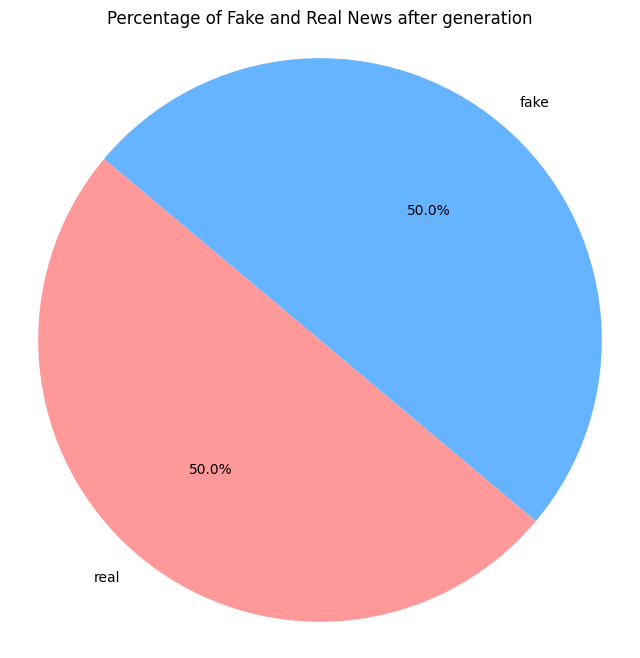

In [381]:
label_counts = combined_df['label'].value_counts()
label_percentages = (label_counts / label_counts.sum()) * 100
print("Percentage of Labels Fake and real after generation :",label_percentages)
# Plot the percentages using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_percentages, labels=label_percentages.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Percentage of Fake and Real News after generation')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### limiting rows and then preparing them for machine learning algorithms

In [382]:
combined_df[['cleaned_news', 'tokens']] = combined_df['news'].apply(lambda x: pd.Series(preprocess_and_tokenize(x)))

### Vectorizing cleaned Text and Data splitting

In [383]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df['cleaned_news'])

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(combined_df['label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



## Applying Models

### Applying Adaboost After Text GEN

In [384]:
# AdaBoost implementation
model = AdaBoostClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))
print("Accuracy: ada boost(simple) after generating text ", accuracy_score(y_test, y_pred))
results_df =store_results("adaboost (simple) after text gen",y_test,y_pred,results_df)


              precision    recall  f1-score   support

        fake       0.86      0.89      0.88       491
        real       0.89      0.85      0.87       491

    accuracy                           0.87       982
   macro avg       0.87      0.87      0.87       982
weighted avg       0.87      0.87      0.87       982

Accuracy: ada boost(simple) after generating text  0.8727087576374746


### Applyng Gboost After Text GEN

In [385]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train and evaluate GBoost
gboost = GradientBoostingClassifier()
gboost.fit(X_train, y_train)
y_pred_gboost = gboost.predict(X_test)
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gboost))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gboost))
results_df =store_results("gboost(simple) after text gen",y_test,y_pred_gboost,results_df)

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88       491
           1       0.92      0.82      0.87       491

    accuracy                           0.87       982
   macro avg       0.88      0.87      0.87       982
weighted avg       0.88      0.87      0.87       982

Gradient Boosting Accuracy: 0.8747454175152749


### Applying XGBoost After Text GEN

In [386]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Initialize the XGBClassifier without specifying any parameters
xgb_model_simple = xgb.XGBClassifier(n_estimators=50,learning_rate=0.001,use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit the model on training data
xgb_model_simple.fit(X_train, y_train)

# Predictions on test data
y_pred_xgb_simple = xgb_model_simple.predict(X_test)

# Evaluation
print("XGBoost Simple Classification Report:\n", classification_report(y_test, y_pred_xgb_simple, zero_division=0))
print("XGBoost Simple Accuracy:", accuracy_score(y_test, y_pred_xgb_simple))
results_df =store_results("XGB after Text-Generation",y_test,y_pred_xgb_simple,results_df)





XGBoost Simple Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.92      0.82       491
           1       0.90      0.68      0.77       491

    accuracy                           0.80       982
   macro avg       0.82      0.80      0.80       982
weighted avg       0.82      0.80      0.80       982

XGBoost Simple Accuracy: 0.8014256619144603


### Applying Logistic Regression After Text GEN

In [387]:
# Logistic Regression
print("Applying Logistic Regression")
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print("Accuracy: (Logistic Regression)", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_, zero_division=0))
results_df = store_results("Logistic Regression after texgen", y_test, y_pred_lr, results_df)


Applying Logistic Regression
Accuracy: (Logistic Regression) 0.890020366598778
              precision    recall  f1-score   support

        fake       0.87      0.92      0.89       491
        real       0.92      0.86      0.89       491

    accuracy                           0.89       982
   macro avg       0.89      0.89      0.89       982
weighted avg       0.89      0.89      0.89       982



### Applying SVM After Text GEN

In [388]:
#Support Vector Machine
print("Applying Support Vector Machine")
model_svm = SVC(random_state=42)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
print("Accuracy: (Support Vector Machine)", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, zero_division=0))
results_df = store_results("Support Vector Machine ater tex gen", y_test, y_pred_svm, results_df)

Applying Support Vector Machine
Accuracy: (Support Vector Machine) 0.9022403258655805
              precision    recall  f1-score   support

        fake       0.88      0.93      0.90       491
        real       0.92      0.88      0.90       491

    accuracy                           0.90       982
   macro avg       0.90      0.90      0.90       982
weighted avg       0.90      0.90      0.90       982



### Appying Random Forest After Text GEN

In [389]:
# Random Forest
print("Applying Random Forest")
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("Accuracy: (Random Forest)", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_, zero_division=0))
results_df = store_results("Random Forest after text gen", y_test, y_pred_rf, results_df)

Applying Random Forest
Accuracy: (Random Forest) 0.90020366598778
              precision    recall  f1-score   support

        fake       0.87      0.94      0.90       491
        real       0.93      0.86      0.90       491

    accuracy                           0.90       982
   macro avg       0.90      0.90      0.90       982
weighted avg       0.90      0.90      0.90       982



### Applyinng Naive Bayes After Text GEN

In [390]:
# Multinomial Naive Bayes
print("Applying Multinomial Naive Bayes")
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
print("Accuracy: (Multinomial Naive Bayes)", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_, zero_division=0))
results_df = store_results("Multinomial Naive Bayes after text gen", y_test, y_pred_nb, results_df)

Applying Multinomial Naive Bayes
Accuracy: (Multinomial Naive Bayes) 0.8044806517311609
              precision    recall  f1-score   support

        fake       0.78      0.85      0.81       491
        real       0.83      0.76      0.80       491

    accuracy                           0.80       982
   macro avg       0.81      0.80      0.80       982
weighted avg       0.81      0.80      0.80       982



### Applying Neuaral Netwrok with 4 layers  After Text GEN

In [391]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from scipy.sparse import csr_matrix
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

# Convert sparse matrices to dense, if necessary
X_train_dense = csr_matrix(X_train).todense()
X_test_dense = csr_matrix(X_test).todense()

# Define the neural network
nn4 = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')  # Use 2 neurons for two classes
])

# Compile the model with appropriate loss function and optimizer
optimizer = Adam(learning_rate=0.001)
nn4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn4.fit(X_train_dense, y_train_encoded, epochs=10, batch_size=16, verbose=1)

# Predict and evaluate the model
y_pred_nn4 = nn4.predict(X_test_dense)
y_pred_nn4 = (y_pred_nn4 > 0.5).astype("int32")

print("Neural Network (4 layers) Classification Report:\n", classification_report(y_test_encoded, y_pred_nn4))
print("Neural Network (4 layers) Accuracy:", accuracy_score(y_test_encoded.argmax(axis=1), y_pred_nn4.argmax(axis=1)))
results_df =store_results("nn4 after text gen",y_test_encoded,y_pred_nn4,results_df)


Epoch 1/10
246/246 [==============================] - 2s 4ms/step - loss: 0.4276 - accuracy: 0.7905
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.0853 - accuracy: 0.9666
Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.0150 - accuracy: 0.9954
Epoch 4/10
246/246 [==============================] - 1s 4ms/step - loss: 0.0112 - accuracy: 0.9980
Epoch 5/10
246/246 [==============================] - 1s 4ms/step - loss: 0.0027 - accuracy: 0.9995
Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.0018 - accuracy: 0.9995
Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.0041 - accuracy: 0.9995
Epoch 8/10
246/246 [==============================] - 1s 4ms/step - loss: 3.4350e-04 - accuracy: 1.0000
Epoch 9/10
246/246 [==============================] - 1s 4ms/step - loss: 1.5173e-04 - accuracy: 1.0000
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Neural Network (4 layers) C

In [392]:
results_df.head(50)

,Model,Accuracy,F1 Score,Recall,Precision
0,ada boost before Text-Generation,0.606098,0.582492,0.606098,0.758549
1,G-boost before Text-Generation,0.598780,0.448514,0.598780,0.358538
2,XGB before Text-Generation,0.768293,0.747302,0.768293,0.803426
3,Logistic Regression before texgen,0.758537,0.729644,0.758537,0.815574
4,Support Vector Machine before texgen,0.598780,0.448514,0.598780,0.358538
5,Random Forest before texgen,0.680488,0.608437,0.680488,0.791659
6,Multinomial Naive Bayes before texgen,0.645122,0.544989,0.645122,0.777180
7,nn4 before text gen,0.759756,0.731280,0.759756,0.816306
8,adaboost (simple) after text gen,0.872709,0.872651,0.872709,0.873392
9,gboost(simple) after text gen,0.874745,0.874407,0.874745,0.878833
